In [11]:
import os
import xml.etree.ElementTree
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk import bigrams
from nltk.tokenize import wordpunct_tokenize
import string
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import math
#nltk.download()

In [6]:
# Se escapearon los & en el archivo y se agregaron los tags <DOCS> para poder parsearlo como un xml
inputXML = './data/ap/ap.txt'
e = xml.etree.ElementTree.parse(inputXML).getroot()
docs = {}

for elem in e.getchildren():
    text = elem.find('TEXT').text
    docno = elem.find('DOCNO').text.strip()
    docs[docno] = text

#docs

In [7]:
def get_wordnet_pos(tag):

    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [8]:
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english') +  list(string.punctuation)
vocabulary = {}
bigrams_map = {}

for docno, text in docs.items():
    sentences = nltk.sent_tokenize(text)
    for sentence in sentences:
        tokens = nltk.word_tokenize(sentence)
        
        for bigram in bigrams(tokens):
            if (bigram[0] not in stop_words) and (bigram[1] not in stop_words):
                bigrams_map.setdefault((bigram[0], bigram[1]), 0)
                bigrams_map.setdefault((bigram[1], bigram[0]), 0)
                bigrams_map[bigram[0],bigram[1]] = bigrams_map[bigram[0],bigram[1]] + 1
                bigrams_map[bigram[1],bigram[0]] = bigrams_map[bigram[1],bigram[0]] + 1
        tags = nltk.pos_tag(tokens)
        for word, tag in tags:
            wornet_pos = get_wordnet_pos(tag)
            if wornet_pos:
                lemma = lemmatizer.lemmatize(word, wornet_pos)
            else:
                lemma = lemmatizer.lemmatize(word)
            if lemma not in stop_words:
                vocabulary.setdefault(lemma, 0)
                vocabulary[lemma] = vocabulary[lemma] + 1


In [9]:
print("El tamaño del vocabulario es", len(vocabulary))

El tamaño del vocabulario es 41169


In [10]:
first_500 = list(map(lambda x: x[0], sorted(vocabulary.items(), key=lambda x: x[1], reverse=True)[:500]))
ordered_bigrams = sorted(bigrams_map.items(), key=lambda x: x[1], reverse=True)

for word in first_500:
    for bigram_entry in ordered_bigrams:
        if bigram_entry[0][0] == word:
            print(word, ",", bigram_entry[0][1])
            break


say , officials
`` , I
'' , said
's , It
The , ``
year , last
would , n't
I , ``
percent , 20
He , said
million , shares
n't , ca
people , million
one , said
also , said
government , 's
make , sure
It , ``
U.S. , District
In , ``
two , years
official , said
report , said
last , year
go , would
take , place
But , ``
A , ``
time , first
state , 's
could , n't
Bush , 's
We , ``
include , would
new , The
get , n't
day , one
first , time
tell , n't
Soviet , Union
week , last
New , York
United , States
company , 's
use , drug
call , 's
billion , 1
work , n't
month , last
country , 's
give , would
come , n't
today , said
plan , 's
president , vice
police , said
Thursday , said
American , people
three , years
group , The
States , United
since , time
Tuesday , said
market , stock
member , states
price , bid
President , Bush
issue , The
Monday , said
Friday , said
high , school
force , task
Wednesday , said
They , ``
know , n't
think , I
want , n't
find , n't
begin , would
charge , possession
le

## 2)

In [12]:
punctuation = list(string.punctuation)
tokens = []
with open('./data/on-the-origin-of-species.txt') as file:  
    data = file.read() 
    tokens = list(filter(lambda x: x not in punctuation, nltk.word_tokenize(data)))
    
len(tokens)

209609

In [13]:
words = ['plants', 'instinct', 'for']

def generate_apparitions_vector(word):
    return [i for i, x in enumerate(tokens) if x == word]

std = 50
std_square = std ** 2
twice_std_square = 2 * std_square
denominator = np.sqrt(2 * np.pi) * std

def gaussian(x):
    x_square = x ** 2 
    exp = (-1) * (x_square / twice_std_square) 
    numerator = np.e ** exp
    return numerator / denominator

text_size = len(tokens)
gaussians = {}
for i in range(text_size):
    gaussians[i] = gaussian(i)
    gaussians[-i] = gaussian(-i)
    
def ro_w(t, apparitions):
    sum = 0
    for i in apparitions:
        sum += gaussians[t - i]
    return sum

def plot_apparitions_from(ro_vector):
    a = [ro_vector[i] for i in range(text_size)]
    plt.plot(a)
    plt.show()
    
    
def calcular_autocorrelacion(tau,ro_vector):
    tamanio = text_size - tau

    acum_ro_i = 0
    acum_ro_it = 0
    acum_ro_i_it = 0
    acum_ro_i_2 = 0
    
    for i in range(tamanio):
        ro_i = ro_vector[i]
        ro_it = ro_vector[i+tau]

        acum_ro_i += ro_i
        acum_ro_it += ro_it
        acum_ro_i_it += ro_i * ro_it

        acum_ro_i_2 += ro_i ** 2

    prom_ro_i_it = acum_ro_i_it / tamanio
    prom_ro_i = acum_ro_i / tamanio
    prom_ro_it = acum_ro_it / tamanio
    prom_ro_i_2 = acum_ro_i_2 / tamanio
    square_prom_ro_i = prom_ro_i ** 2
    
    autocorrelacion = (prom_ro_i_it - (prom_ro_i * prom_ro_it)) / (prom_ro_i_2 - square_prom_ro_i)
    return autocorrelacion

def plot_autocorrelation_from(ro_vector):
    rangos = np.arange(0, 10000, 50) #[10, 50, 100, 250, 500, 750, 1000]

    a = [calcular_autocorrelacion(tao,ro_vector) for tao in rangos]
        
    plt.plot(a)
    plt.show()
    
    
def calculate_ro_vector(apparitions):
    ro_vector = [ro_w(i, apparitions) for i in range(text_size)]
    return ro_vector


def graficos(words):
    for word in words:
        apparitions = generate_apparitions_vector(word)

        ro_vector = calculate_ro_vector(apparitions)
        
        plot_apparitions_from(ro_vector)
        plot_autocorrelation_from(ro_vector)

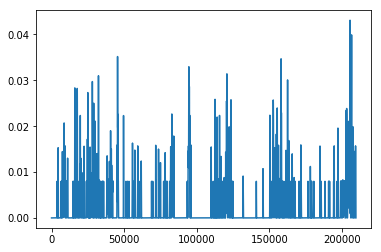

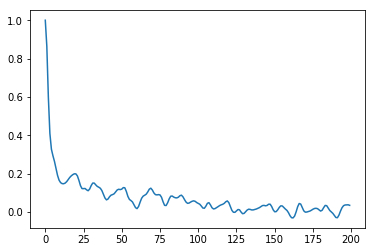

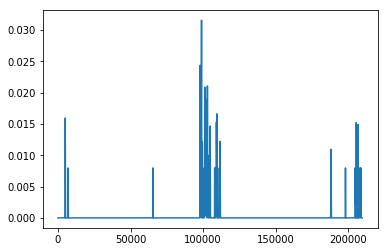

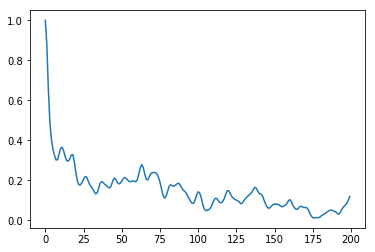

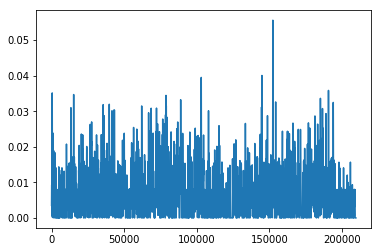

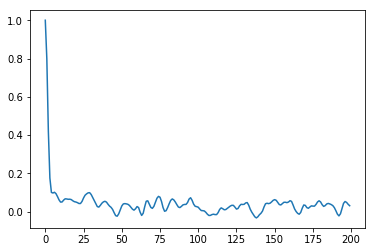

In [14]:
graficos(words)

In [101]:
import operator as op
def nCr(n, r):
    n = int(n)
    r = int(r)
    #print(n, r, min(r, n-r))
    r = min(r, n-r)
    if r == 0: return 1
    #numer = functools.reduce(op.mul, np.arange(n, n-r, -1))
    numer = functools.reduce(op.mul, range(n-r, n, 1))
    denom = functools.reduce(op.mul, range(1, r+1))
    return numer//denom

In [102]:
comb_N_NdivP = nCr(209609, 3275)

In [106]:
def entropy(word):
    apparitions = generate_apparitions_vector(word)
    
    N = text_size
    P = 64
    longitud_P = N // P
    n = len(apparitions)

    acum = 0
    
    p_w = n / N

    #h_w = H(word, apparitions, P, longitud_P, n)
    print("n, N, P", n, N, P)
    H_w_mean = H_mean_w(n, N, P)
    

    #acum += p_w * (H_w - h_w)

    return H_w_mean

def H_mean_w(n, N, P):
    cota = min(n,N/P)
    #print("cota:", cota)
    return (-P) * sum(map(lambda m: internal_function(m, n, N, P), [m for m in range(1,cota+1)]))
    
def internal_function(m, n, N, P):
    aux = (m/n) * np.log2(m/n) * marginal_probability(m, n, N, P) 
    return aux
    
    
def H(word, apparitions, P, longitud_P, n):
    ocurrencias = [calcular_particiones(apparitions, word, i, longitud_P) for i in range(P)] 
    acum = 0
    for i in range(P):
        calculo = ocurrencias[i] / n
        if calculo != 0:
            acum += calculo * np.log2(calculo)
    
    return - acum
    

def calcular_particiones(apparitions,word,i,cota):
    return len(list(filter(lambda x: i*cota <= x <= (i+1)*cota, apparitions)))
    


def nCrbuuuuu(n,r):
    n = int(n)
    r = int(r)
    f = math.factorial
    print('n: ', f(n))
    print('r: ', f(r))
    print('n-r: ', f(n-r))
    return f(n) / f(r) / f(n-r)
        
def marginal_probability(m, n, N, P):
    print("m, n, N, P", m, n, N, P)
    a = nCr(n,m)
    b = nCr((N-n), (N/P)-m)
    #c = nCr(N,(N/P))
    c = comb_N_NdivP
    print(a,b)
    return a * b / c


entropy(words[1])

n, N, P 72 209609 64
m, n, N, P 1 72 209609 64
71 98491029445262367340475144081116447550876866647615786863378540818115502062593185971071167431942182134355239458923715583805969342116681759595365460047821588286423610151332651619914723349555662322217661950281255358962000640113019853266543518401058337643324536650571843714816172297220141046290900527596844941968001901291404137827083111704150337227045355481950305639079489590575423958860612521490041910587692460497550043409393212690427773014937142421677504623912767634031112654296065781108412608710077122282601064059014923988317748471768447733160724541632826507333415527259672466771407328736381725736631033147269366728159837999744604073625164413943068970442522224892633530919033340517561339879921372632940388225749337518552336976727576019957993401616672445421309705828001329639034973800271017862867833913273960663774933339119781540111932179473571537963196403738234599693195151582867105076618313386278042854091082399800170926972590500387269826016706280031

m, n, N, P 3 72 209609 64
57155 24807133938825782856103747522405279792402020340911683000102138350000496326625227383287873116802440071487140946691223631244341152956227180716302236069900352155031796222022345498315220480498232969713805331765220232266219068730852094543850403230097906860038734216605096009635460055403405377516495591847940355729501215669674179889737136283991150781730130334348833455134755313671730134479696187370370685352971564639985990847881946867737794319247528900216907804658818444698140569923719965564775139905615855685388160761296408743651219549934430743663638241497179872735403998500908972189259420544225829442650095591068449487381344776702806149282348402252812031355757275150930074130562967721627736887993196346907957814136957182042845007572924285048203014575612126647099669915671636700256800812491564981738795390477574609649065398094772082760642190552077664397924732962603369624169129921021676376341646522723718683922971561493147200043999648515533220101477013753873700460120350552

5.1230571338333553

In [81]:
marginal_probability(20, 72, 209609, 64)

m, n, N, P 20 72 209609 64
-1 0 0


C:\Users\mguerson\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in long_scalars
  import sys
C:\Users\mguerson\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in longlong_scalars


-inf